In [18]:
import re

def get_length(formula):
    groups = re.findall(r"([A-Z][a-z]?) ?(\d+)", formula)
    cnt = 0
    for atom, count in groups:
        cnt += int(count)
    return cnt

def convert_formula_to_counts(formula):
    groups = re.findall(r"([A-Z][a-z]?)(\d+)", formula)
    counts = {}
    for atom, count in groups:
        counts[atom] = int(count) if count else 1
    return counts

def flatten_to_formula(flatten):
    # A A B B B <sgx> -> A 2 B 3 <sgx>
    groups = re.search(r"(.+) (<sg.+>)", flatten)
    if not groups:
        return None
    flatten = groups.group(1)
    sg = groups.group(2)
    elements = flatten.split()
    counts = {}
    for element in elements:
        if element in counts:
            counts[element] += 1
        else:
            counts[element] = 1
    formula = " ".join(f"{element} {count}" for element, count in counts.items())
    formula = f"{formula} {sg}"
    return formula
    

def formula_to_flatten(formula):
    # A2B3 -> A A B B B
    groups = re.findall(r"([A-Z][a-z]*)(\d*)", formula)
    elements = [atom for atom, count in groups for _ in range(int(count))]
    flatten = " ".join(elements)
    return flatten

In [19]:
train_data = set() # all in A a.b B c.d format

In [20]:
import re
exist_train_path = "/msralaphilly2/ml-la/shufxi/data/scigpt/CrystalLLM/train.txt"
with open(exist_train_path, "r") as f:
    for line in f:
        line = line.strip()
        line = line.replace("<material>", "").replace("</material>", "")
        if not re.search(r"(.+?) <sg.+>", line):
            continue
        formula = flatten_to_formula(line)
        if formula:
            train_data.add(formula)

In [21]:
val_path = "/msralaphilly2/ml-la/shufxi/data/scigpt/CrystalLLM/valid.txt"
val_data = set()
with open(val_path, "r") as f:
    for line in f:
        line = line.strip()
        line = line.replace("<material>", "").replace("</material>", "")
        if not re.search(r"(.+?) <sg.+>", line):
            continue
        formula = flatten_to_formula(line)
        if formula:
            val_data.add(formula)

In [22]:
print(len(train_data))
print(list(train_data)[:10])
print(list(val_data)[:10])

1108731
['Li 1 Pd 1 Sb 1 <sg216>', 'Ce 1 Co 1 Er 2 <sg225>', 'Ba 2 O 2 Se 2 Sr 2 <sg63>', 'Nb 1 Si 1 Y 1 <sg216>', 'Lu 32 <sg99>', 'Al 3 Cu 3 Er 3 <sg189>', 'Cu 1 Te 2 Zr 6 <sg189>', 'Au 3 Zn 1 <sg225>', 'Th 1 Tl 3 Tm 2 <sg164>', 'Al 1 Pm 1 <sg123>']
['Mg 3 B 1 Se 1 Cl 3 <sg176>', 'U 1 S 2 <sg62>', 'Ag 1 P 3 Pb 1 O 9 <sg1>', 'Nb 1 Pb 2 S 8 Br 1 <sg1>', 'Ag 3 P 3 O 10 <sg12>', 'Li 2 Tm 3 Te 5 Br 1 <sg15>', 'Ca 1 Te 1 P 2 S 7 <sg62>', 'Ni 1 H 10 C 14 S 10 N 1 O 2 <sg2>', 'Sr 1 Eu 2 S 1 Cl 2 <sg139>', 'Cr 2 Ni 1 Te 1 F 6 <sg14>']


In [23]:
import glob
from tqdm import tqdm
data_folder = "/home/renqianluo/ef_p_sg_w"
for file in tqdm(glob.glob(f"{data_folder}/*")):
    with open(file, "r") as f:
        for line in f:
            line = line.strip().split("_")
            formula = line[0]
            for e in line[2:]:
                if e.isdigit():
                    sg = e
            groups = re.findall(r"([A-Z][a-z]*)(\d+)", formula)
            formula = []
            for atom, count in groups:
                formula.append(atom)
                formula.append(count)
            formula.append(f"<sg{sg}>")
            formula = " ".join(formula)
            if formula not in val_data:
                train_data.add(formula)

  0%|          | 3/18643 [00:00<12:57, 23.97it/s]

100%|██████████| 18643/18643 [10:06<00:00, 30.73it/s]


In [24]:
print(len(train_data))
print(list(train_data)[:10])
print(list(train_data)[-10:])

15800183
['Bi 4 Pb 3 Se 1 O 12 <sg6>', 'Nb 1 Si 1 Y 1 <sg216>', 'Lu 32 <sg99>', 'Ba 5 Al 4 S 7 I 2 <sg1>', 'Na 1 B 5 H 8 O 13 <sg15>', 'Yb 1 Ni 3 Sb 1 O 7 <sg1>', 'Eu 1 Lu 2 Sb 1 O 7 <sg63>', 'Ga 1 Tc 8 S 24 Cl 13 <sg148>', 'Si 3 Ru 1 Pt 1 <sg221>', 'Yb 2 Sm 5 H 1 S 10 <sg12>']
['As 3 Cs 1 Y 4 <sg123>', 'As 6 Pd 2 S 17 <sg14>', 'Bi 3 As 3 S 1 O 13 <sg11>', 'Tl 2 Zn 1 P 2 O 52 <sg14>', 'Lu 2 Cd 2 P 4 O 11 <sg15>', 'Ce 1 Pt 7 W 2 O 73 <sg2>', 'As 1 Ca 1 Rh 6 Sb 3 <sg187>', 'Tb 1 Ho 1 Ru 1 Au 1 <sg216>', 'Mg 1 Co 4 As 1 O 52 <sg14>', 'Au 3 H 1 <sg225>']


In [25]:
import pandas as pd
df=pd.read_csv("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/structures2/deduplicate_structures.csv", sep=",", header=0)

In [4]:
import re
from tqdm import tqdm
ddf = []
for line in tqdm(df["structure"]):
    formula = []
    for e in line.split():
        if e.startswith("<i>"):
            formula.append(e.replace("<i>", "").replace("</i>", ""))
        if re.search(r"<sg.+>", e):
            sg = e
    formula.append(sg)
    formula = " ".join(formula)
    ddf.append(formula)
ddf = pd.DataFrame(ddf, columns=["formula"])
print(len(ddf))
dedup_ddf = ddf.drop_duplicates(subset=["formula"])
print(len(dedup_ddf))

100%|██████████| 39859005/39859005 [04:36<00:00, 144392.21it/s]


In [26]:
import re
from tqdm import tqdm
for line in tqdm(df["structure"]):
    formula = []
    for e in line.split():
        if e.startswith("<i>"):
            formula.append(e.replace("<i>", "").replace("</i>", ""))
        if re.search(r"<sg.+>", e):
            sg = e
    formula.append(sg)
    formula = " ".join(formula)
    if formula not in val_data:
        train_data.add(formula)


100%|██████████| 39859005/39859005 [04:49<00:00, 137857.99it/s]


In [27]:
print(len(train_data))
print(list(train_data)[:10])
print(list(train_data)[-10:])

28617570
['Bi 4 Pb 3 Se 1 O 12 <sg6>', 'Nb 1 Si 1 Y 1 <sg216>', 'Lu 32 <sg99>', 'Ho 4 Ga 1 B 1 O 4.3 <sg1>', 'Eu 1 Lu 2 Sb 1 O 7 <sg63>', 'Si 3 Ru 1 Pt 1 <sg221>', 'Ce 4 Eu 1 Cr 1 S 4.3 <sg1>', 'Cu 3 Sb 4 Pd 2 O 11 <sg2>', 'Ba 2 Na 3 Ta 1 S 6 <sg70>', 'V 4 Hg 2 S 11 <sg12>']
['Y 1 Co 2 Rh 1 O 5 <sg15>', 'Eu 7 Tl 2 Br 17 N 3.2 <sg12>', 'Ho 2 Fe 1 Mo 1 S 6 <sg123>', 'As 3 Cs 1 Y 4 <sg123>', 'As 6 Pd 2 S 17 <sg14>', 'Bi 3 As 3 S 1 O 13 <sg11>', 'Tl 2 Hg 1 N 2 O 7 <sg55>', 'Ce 1 Pt 7 W 2 O 73 <sg2>', 'Na 2 Tm 8 Pb 6 O 19 <sg12>', 'Au 3 H 1 <sg225>']


In [28]:
from tqdm import tqdm
with open("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/structures2/train_cf_sg.txt", "w") as f:
    for formula in tqdm(train_data):
        res = []
        line = formula.split()
        for i in range(0, len(line)-1, 2):
            res.append(line[i])
            res += line[i+1]
        res.append(line[-1])
        res = " ".join(res)
        res = f"<cf1>{res}</cf1>"
        f.write(res + "\n")

100%|██████████| 28617570/28617570 [00:54<00:00, 521110.06it/s]


In [29]:
from tqdm import tqdm
with open("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/structures2/train_cf.txt", "w") as f:
    for formula in tqdm(train_data):
        res = []
        line = formula.split()
        for i in range(0, len(line)-1, 2):
            res.append(line[i])
            res += line[i+1]
        res = " ".join(res)
        res = f"<cf2>{res}</cf2>"
        f.write(res + "\n")

  0%|          | 53932/28617570 [00:00<00:52, 539303.80it/s]

100%|██████████| 28617570/28617570 [00:49<00:00, 582715.38it/s]


In [30]:
from tqdm import tqdm
with open("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/structures2/train_fcf_sg.txt", "w") as f:
    for formula in tqdm(train_data):
        if "." in formula:
            continue
        length = get_length(formula)
        if length > 100:
            continue
        res = []
        line = formula.split()
        for i in range(0, len(line)-1, 2):
            res += [line[i]] * int(line[i+1])
        res.append(line[-1])
        res = " ".join(res)
        res = f"<fcf>{res}</fcf>"
        f.write(res + "\n")

100%|██████████| 28617570/28617570 [01:41<00:00, 282171.37it/s]


In [2]:
with open("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/structures2/text_to_material_fcf_sg.txt", "w") as fw:
    with open("/msralaphilly2/ml-la/shufxi/data/scigpt/text2material/train.txt", "r") as fr:
        for line in fr:
            line = line.strip()
            line = line.replace("<material>", "<fcf>").replace("</material>", "</fcf>")
            fw.write(line + "\n")

In [4]:
import re

def flatten_to_formula(flatten, sg=True):
    # A A B B B <sgx> -> A 2 B 3 <sgx>
    groups = re.search(r"(.+) (<sg.+>)", flatten)
    if not groups:
        return None
    flatten = groups.group(1)
    sg = groups.group(2)
    elements = flatten.split()
    counts = {}
    for element in elements:
        if element in counts:
            counts[element] += 1
        else:
            counts[element] = 1
    formula = []
    for element, count in counts.items():
        formula.append(element)
        formula += str(count)
    formula = " ".join(formula)
    if sg:
        formula = f"{formula} {sg}"
    return formula


files = ["/msralaphilly2/ml-la/shufxi/data/scigpt/text2material/train.txt",
         "/msralaphilly2/ml-la/shufxi/data/scigpt/materials_project_data/train_x10.txt"]

with open("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/text_and_material_cf_sg.txt", "w") as fw:
    for fname in files:
        with open(fname, "r") as fr:
            for line in fr:
                line = line.strip()
                groups = re.search(r"(<material>(.*)</material>)", line).groups()
                seq = groups[0]
                fcf = groups[1]
                formula = flatten_to_formula(fcf)
                if formula:
                    new_seq = f"<cf1>{formula}</cf1>"
                    new_line = line.replace(seq, new_seq)
                    fw.write(new_line + "\n")

with open("/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/material/text_and_material_fcf_sg.txt", "w") as fw:
    for fname in files:
        with open(fname, "r") as fr:
            for line in fr:
                line = line.strip()
                new_line = line.replace("<material>", "<fcf>").replace("</material>", "</fcf>")
                fw.write(new_line + "\n")


In [ ]:
from glob import glob
from tqdm import tqdm
import re

def get_length(formula):
    groups = re.findall(r"([A-Z][a-z]*) ?(\d*)", formula)
    cnt = 0
    for atom, count in groups:
        cnt += int(count)
    return cnt


lengths = []
for fname in tqdm(glob("/home/renqianluo/ef_p_sg_w/*")):
    with open(fname, "r") as f:
        for line in f:
            line = line.strip().split("_")
            formula = line[0]
            cnt = get_length(formula)
            lengths.append(cnt)

In [22]:
# get statistics of the lengths
import numpy as np
print(np.mean(lengths))
print(np.std(lengths))
print(np.median(lengths))
for i in range(0, 110, 10):
    print(f"{i}th percentile: {np.percentile(lengths, i)}")

18507.974002273728
5483014.800388767
12.0
0th percentile: 1.0
10th percentile: 6.0
20th percentile: 8.0
30th percentile: 9.0
40th percentile: 11.0
50th percentile: 12.0
60th percentile: 17.0
70th percentile: 25.0
80th percentile: 39.0
90th percentile: 62.0
100th percentile: 5255288521.0


In [23]:
for i in range(90, 101, 1):
    print(f"{i}th percentile: {np.percentile(lengths, i)}")

90th percentile: 62.0
91th percentile: 69.0
92th percentile: 79.0
93th percentile: 90.0
94th percentile: 111.0
95th percentile: 164.0
96th percentile: 271.0
97th percentile: 850.0
98th percentile: 4809.0
99th percentile: 28113.0
100th percentile: 5255288521.0


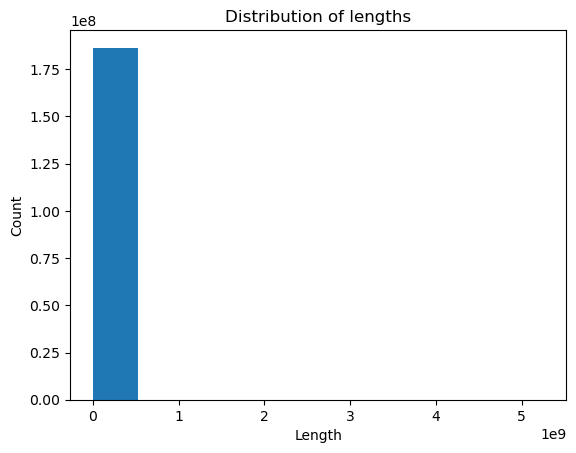

<Figure size 640x480 with 0 Axes>

In [24]:
# distribution of lengths
import matplotlib.pyplot as plt
plt.hist(lengths, bins=10)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of lengths")
plt.show()
plt.savefig("lengths.png")